In [1]:
import pandas as pd
import numpy as np
import spacy
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.models import Model, Input
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, concatenate, SpatialDropout1D
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import classification_report

Using TensorFlow backend.
c:\program files\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
nlp = spacy.load("en_core_web_lg")

In [3]:
df = pd.read_csv("Data/ner.tsv", sep="\t")

In [4]:
tags = list(sorted(df.tag.unique().tolist()))
uds_tags = [
    "ADJ", "ADP", "ADV", "AUX",
    "CONJ", "CCONJ", "DET", "INTJ",
    "NOUN", "NUM", "PART", "PRON",
    "PROPN", "PUNCT", "SCONJ", "SYM",
    "VERB", "X", "SPACE"
]

In [5]:
grouped_data = dict(list(df.groupby(["document_id", "line"])))
sentences = [g["token"].tolist() for k, g in grouped_data.items()]
pos_tags = [g["token_pos"].tolist() for k, g in grouped_data.items()]
sentence_tags = [g["tag"].tolist() for k, g in grouped_data.items()]

In [6]:
words = list(sorted(df.token.unique()))
tags = ["<PAD>"] + list(sorted(df.tag.unique()))
# uds_tags = ["<PAD>"] + uds_tags
chars = set([w_i for w in words for w_i in w])

n_words = len(words)
n_tags = len(tags)
n_chars = len(chars)

print("-"*50)
print(f"Number of sentences: \t\t{len(sentences)}")
print(f"Number of unique words: \t{n_words}")
print(f"Number of unique tags: \t\t{n_tags}")
print(f"Number of unique chars: \t{n_chars}")
print("-"*50)

--------------------------------------------------
Number of sentences: 		337
Number of unique words: 	1220
Number of unique tags: 		10
Number of unique chars: 	97
--------------------------------------------------


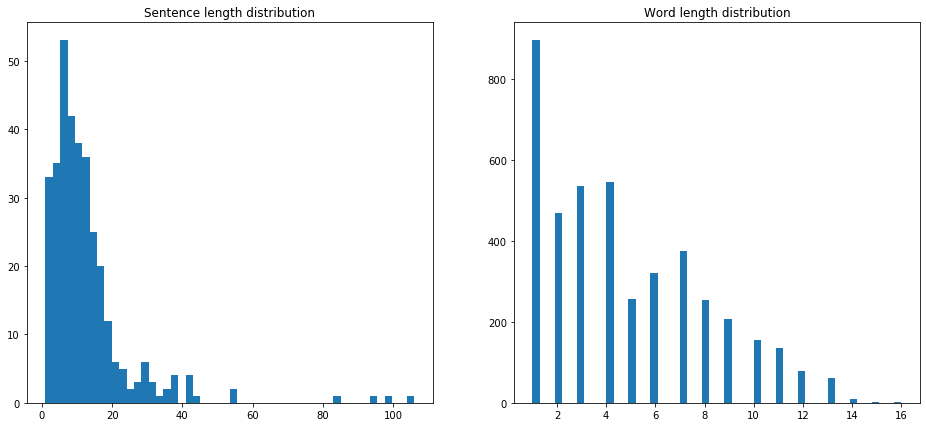

In [12]:
plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
plt.title("Sentence length distribution")
plt.hist([len(s) for s in sentences], bins=50)

plt.subplot(1, 2, 2)
plt.title("Word length distribution")
plt.hist([len(w) for s in sentences for w in s], bins=50)

plt.show()

In [8]:
max_len = 50
batch_size = 32

tag2idx = {t: i for i, t in enumerate(tags)}
uds_tag2idx = {t: i for i, t in enumerate(uds_tags)}
idx2tag = {i: t for i, t in enumerate(tags)}
idx2uds_tag = {i: t for i, t in enumerate(uds_tags)}

In [9]:
def vectorize_sentence(s):
    if type(s) is str:
        s = nlp(s)
    result = []
    for w in s:
        result.append(nlp(w).vector)
        
    return result

def pos2idx(tags):
    result = []
    for tag in tags:
        v = np.zeros(len(uds_tags))
        idx = uds_tag2idx[tag]
        v[idx] = 1
        result.append(v)
        
    return result

In [10]:
X_token = [vectorize_sentence(s) for s in sentences]
X_token = pad_sequences(X_token, maxlen=max_len, padding="post", dtype=object, value=np.zeros(300))

X_pos = [pos2idx(s) for s in pos_tags]
X_pos = pad_sequences(X_pos, maxlen=max_len, padding="post", dtype=object, value=np.zeros(len(uds_tags)))

y = [[tag2idx[t] for t in s] for s in sentence_tags]
y = pad_sequences(y, maxlen=max_len, padding="post", dtype=object, value=tag2idx["<PAD>"])
y = [to_categorical(x, num_classes=n_tags) for x in y]

In [31]:
# X_token_train, X_token_test, y_train, y_test = train_test_split(X_token, y, test_size=0.1)
X_token_train, X_token_test, X_pos_train, X_pos_test, y_train, y_test = train_test_split(X_token, X_pos, y, test_size=0.1)

In [32]:
token_input = Input(shape=(max_len,300))
pos_input = Input(shape=(max_len,len(uds_tags)))

token_branch_bilstm = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.1))(token_input)
pos_branch_bilstm = Bidirectional(LSTM(units=16, return_sequences=True,
                           recurrent_dropout=0.1))(pos_input)
token_model = Model(token_input, token_branch_bilstm)
pos_model = Model(pos_input, pos_branch_bilstm)

combined = concatenate([token_model.output, pos_model.output])

time_dist = TimeDistributed(Dense(256, activation="relu"))(combined)
crf = CRF(n_tags)
z = crf(time_dist)

# input_ = Input(shape=(max_len,300))
# model = Bidirectional(LSTM(units=256, return_sequences=True,
#                            recurrent_dropout=0.1))(input_)
# model = TimeDistributed(Dense(256, activation="relu"))(model)
# crf = CRF(n_tags)  # CRF layer
# output_ = crf(model)  # output

In [33]:
model = Model(inputs=[token_model.input, pos_model.input], outputs=z)
# model = Model(input_, output_)

In [34]:
model.compile(optimizer="adam", loss=crf_loss, metrics=[crf.accuracy])

In [35]:
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 50, 19)       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 512)      1140736     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 50, 32)       4608        input_3[0][0]                    
____________________________________________________________________________________________

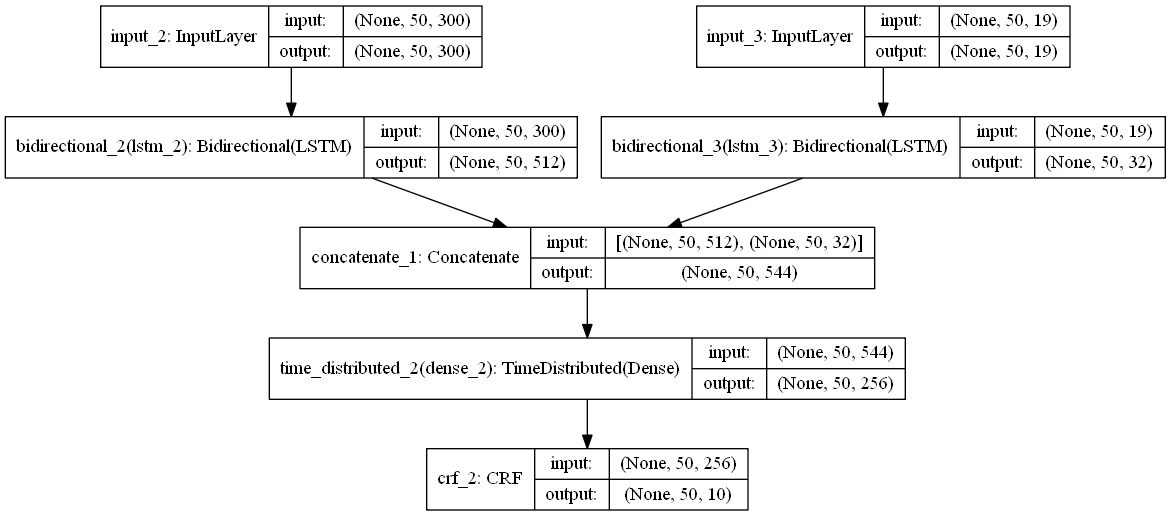

In [36]:
plot_model(model, show_shapes=True)

In [37]:
# history = model.fit(X_token_train, np.array(y_train), batch_size=8, epochs=11,
#                     validation_split=0.1, verbose=1)

history = model.fit([X_token_train, X_pos_train], np.array(y_train), batch_size=8, epochs=10,
                    validation_split=0.1, verbose=1)

Train on 272 samples, validate on 31 samples
Epoch 1/10
272/272 [==============================] - 9s 34ms/step - loss: 0.4857 - crf_viterbi_accuracy: 0.8590 - val_loss: 0.1840 - val_crf_viterbi_accuracy: 0.9588
Epoch 2/10
272/272 [==============================] - 7s 26ms/step - loss: 0.1064 - crf_viterbi_accuracy: 0.9724 - val_loss: 0.1425 - val_crf_viterbi_accuracy: 0.9607
Epoch 3/10
272/272 [==============================] - 7s 26ms/step - loss: 0.0896 - crf_viterbi_accuracy: 0.9743 - val_loss: 0.1497 - val_crf_viterbi_accuracy: 0.9613
Epoch 4/10
272/272 [==============================] - 7s 27ms/step - loss: 0.0767 - crf_viterbi_accuracy: 0.9765 - val_loss: 0.1201 - val_crf_viterbi_accuracy: 0.9613
Epoch 5/10
272/272 [==============================] - 7s 27ms/step - loss: 0.0548 - crf_viterbi_accuracy: 0.9829 - val_loss: 0.1213 - val_crf_viterbi_accuracy: 0.9613
Epoch 6/10
272/272 [==============================] - 7s 28ms/step - loss: 0.0437 - crf_viterbi_accuracy: 0.9832 - val_l

In [38]:
y_test_pred = model.predict([X_token_test, X_pos_test])
y_train_pred = model.predict([X_token_train, X_pos_train])
# y_test_pred = model.predict(X_token_test)
# y_train_pred = model.predict(X_token_train)

In [39]:
test_report = classification_report(np.array(y_test).reshape((max_len * len(y_test), n_tags)), 
                                    y_test_pred.reshape((max_len * len(y_test), n_tags)), 
                                    target_names=tags)
train_report = classification_report(np.array(y_train).reshape((max_len * len(y_train), n_tags)), 
                                    y_train_pred.reshape((max_len * len(y_train), n_tags)), 
                                    target_names=tags)

In [40]:
print(test_report)
print("-"*50)
print(train_report)

              precision    recall  f1-score   support

       <PAD>       1.00      1.00      1.00      1278
       B-exp       1.00      1.00      1.00         1
     B-skill       0.67      0.33      0.44         6
       I-exp       0.33      1.00      0.50         1
     I-skill       1.00      0.67      0.80         3
       L-exp       0.00      0.00      0.00         1
     L-skill       1.00      0.50      0.67         6
           O       0.98      0.99      0.98       395
       U-exp       0.00      0.00      0.00         0
     U-skill       0.73      0.89      0.80         9

   micro avg       0.99      0.99      0.99      1700
   macro avg       0.67      0.64      0.62      1700
weighted avg       0.99      0.99      0.99      1700
 samples avg       0.99      0.99      0.99      1700

--------------------------------------------------
              precision    recall  f1-score   support

       <PAD>       1.00      1.00      1.00     11464
       B-exp       0.90    

In [48]:
x_t = np.zeros((max_len, 300))
x_p = np.zeros((max_len, len(uds_tags)))

sentence = "3 years of experience in Scala and Haskell."
# sentence = "Proven track record of projects like Dota, CS:GO and WarCraft."
# sentence = "3 years of experience in project management"
# sentence = "Writing unit tests, integration tests"
# sentence = "Development of ML models with Tensorflow, Pytorch."
# sentence = "Experience in enterprise application architecture development."


doc = nlp(sentence)

for i, token in enumerate(doc):
    x_t[i] = token.vector
    x_p[i][uds_tag2idx[token.pos_]] = 1
    
# p = model.predict(np.array([x_t]))[0]
p = model.predict([np.array([x_t]), np.array([x_p])])[0]

p = np.argmax(p, axis=-1)

print("{:15} {:5}".format("Word", "Pred"))
print("-"*30)

for i, token in enumerate(doc):
    print("{:15}:{:5}".format(token.text, idx2tag[p[i]]))

# for w, pred in zip(x_t[0], p):
#     if w != "<PAD>":
#         print("{:15}:{:5}".format(w, idx2tag[pred]))

Word            Pred 
------------------------------
3              :B-exp
years          :I-exp
of             :O    
experience     :O    
in             :O    
Scala          :U-skill
and            :O    
Haskell        :U-skill
.              :O    
